# E-커머스 전자기기 구매 행동 분석

### 프로젝트 개요
- **분석 이유**: 전자기기 같은 상대적으로 고가의 물품 및 오래 사용할 물건을 살 때
고객의 구매 행동 패턴 파악


- **분석 목표**: 고가 전자기기 구매 고객의 행동 패턴을 분석하여 마케팅 인사이트 도출
> 1. 첫 구매 후 재구매까지 걸리는 시간 분석 - 전자기기 특성
> 2. 카테고리별 추가 구매 패턴 분석 - 세트 상품 가능성
> 3. 세션 기반 고객 행동 분석 - 한 세션에 오래 머문 고객과 그렇지 못한 고객 행동 파악      

## IMPORT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns

# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf' 
font_prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

## DATALOAD

In [2]:
data = pd.read_csv("data/events.csv")

데이터 출처 : https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-electronics-store

2020-09-24 ~ 2021-02-28 약 5개월간 데이터

## DATA INFO

### 컬럼 정보  


event_time  : 이벤트 발생 시간  
event_type  : 이벤트 타입  
product_id  : 상품 id  
category_id	 : 상품 카테고리 id  
category_code  : 상품 카테고리 코드  
brand  : 브랜드  
price  : 가격  
user_id	 : 고객 id  
user_session : 고객 세션  



In [4]:
data.head(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category_code_1,category_code_2
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT,electronics,telephone
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY,computers,cooler
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy,NaN,NaN
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08,computers,printer
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   event_time       885129 non-null  object 
 1   event_type       885129 non-null  object 
 2   product_id       885129 non-null  int64  
 3   category_id      885129 non-null  int64  
 4   category_code    648910 non-null  object 
 5   brand            672765 non-null  object 
 6   price            885129 non-null  float64
 7   user_id          885129 non-null  int64  
 8   user_session     884964 non-null  object 
 9   category_code_1  648910 non-null  object 
 10  category_code_2  648910 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 74.3+ MB


In [6]:
data['user_id'].nunique()

407283

In [7]:
data['event_type'].value_counts()

event_type
view        793748
cart         54035
purchase     37346
Name: count, dtype: int64

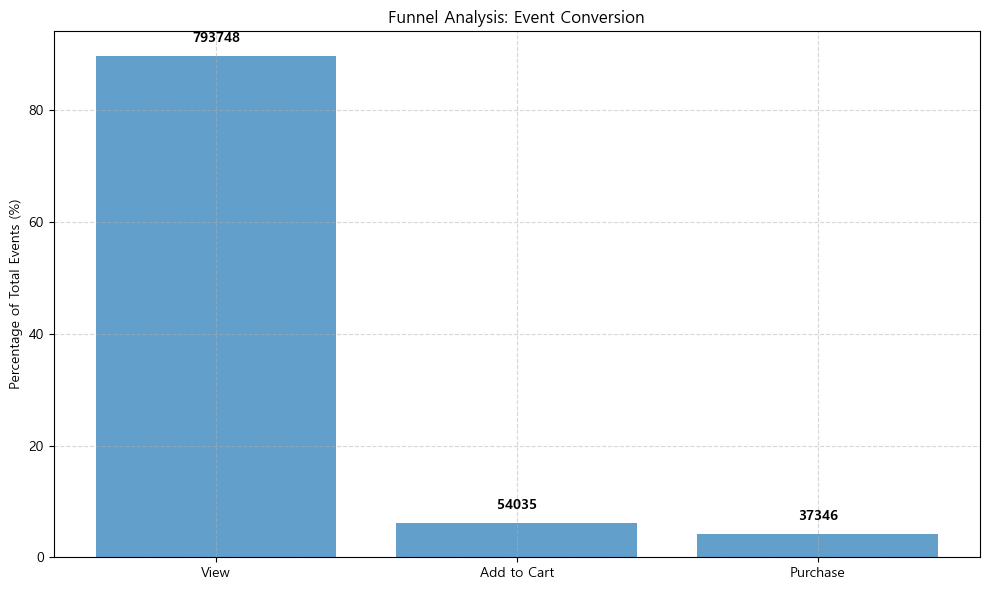

In [8]:
# 시각화
view_count = len(data[data['event_type'] == 'view'])
add_to_cart_count = len(data[data['event_type'] == 'cart'])
purchase_count = len(data[data['event_type'] == 'purchase'])

total_events = view_count + add_to_cart_count + purchase_count
view_percentage = view_count / total_events * 100 if total_events > 0 else 0
add_to_cart_percentage = add_to_cart_count / total_events * 100 if total_events > 0 else 0
purchase_percentage = purchase_count / total_events * 100 if total_events > 0 else 0

stages = ['View', 'Add to Cart', 'Purchase']
counts = [view_count, add_to_cart_count, purchase_count]
percentages = [view_percentage, add_to_cart_percentage, purchase_percentage]

fig, ax1 = plt.subplots(figsize=(10, 6))

# 막대 그래프: 각 단계별 이벤트 비율 (0~100%)
ax1.bar(stages, percentages, alpha=0.7)

# 막대 위에 건수 표시
for i, v in enumerate(counts):
    ax1.text(i, percentages[i] + 2, str(v), ha='center', va='bottom', fontweight='bold')

ax1.set_ylabel('Percentage of Total Events (%)')
ax1.set_title('Funnel Analysis: Event Conversion')

# 그리드 추가
ax1.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [9]:
data['user_id'].value_counts()

user_id
1515915625554995474    572
1515915625527763086    424
1515915625591251010    363
1515915625591659523    339
1515915625537803839    329
                      ... 
1515915625541761876      1
1515915625541762343      1
1515915625541762272      1
1515915625541762044      1
1515915625611024030      1
Name: count, Length: 407283, dtype: int64

### - 중복 데이터 확인

In [10]:
data.duplicated().sum()

655

In [11]:
# 중복 데이터 제거 - 초 단위의 이벤트 발생 시간 > 중복이 나올 수 없는 구조
data.drop_duplicates(inplace=True)

### - 결측치 확인

In [12]:
data.isnull().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code      236047
brand              212232
price                   0
user_id                 0
user_session          162
category_code_1    236047
category_code_2    236047
dtype: int64

In [13]:
# category_code 결측치 처리
# category_id는 모두 존재
# category_code가 NaN일 때 같은 category_id가 있고 code도 있을 경우 확인
# (같은 category_id의 code로 채울 가능성 있음)

In [14]:
nan_code = data[data['category_code'].isna()]['category_id']

# 개수 확인
print(len(nan_code))

236047


결측치 236047 == 236047 위 코드 결과  
category_code가 NaN일 때 category_id 값도 NaN 인것 증명  
결측치 elect.etc로 처리

In [15]:
data['category_code'] = data['category_code'].fillna('elect.etc')

In [16]:
# brand 결측치 처리
# brand의 경우 etc 로 처리(기타 브랜드는 공백처리한듯) 
data['brand'] = data['brand'].fillna('etc')

In [17]:
# user_session 결측치 처리
# 세션 분석에서만 문제가 되므로(구매가 있을 수 있으므로) 추후세션 분석에서만 제외
data_for_session = data.dropna()

In [18]:
data.isnull().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code           0
brand                   0
price                   0
user_id                 0
user_session          162
category_code_1    236047
category_code_2    236047
dtype: int64

___

## 구매 시기 기반 코호트 분석

전자기기는 한 번 구매하면 오랫동안 사용하는 제품이 많다. 하지만 일부 고객은 주기적으로 최신 제품을 구매하거나, 첫 구매 후 추가 액세서리를 구매할 가능성이 있다. 이를 분석하면, 고객이 재구매하는 데 걸리는 시간과 패턴을 이해할 수 있다.

In [19]:
# datetime 변경
data['event_time'] = pd.to_datetime(data['event_time'], errors='coerce')

# 변환이 잘 되었는지 확인
print(data.dtypes)

event_time         datetime64[ns, UTC]
event_type                      object
product_id                       int64
category_id                      int64
category_code                   object
brand                           object
price                          float64
user_id                          int64
user_session                    object
category_code_1                 object
category_code_2                 object
dtype: object


C:\Users\whgus\AppData\Local\Temp\ipykernel_8768\1914587151.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['cohort_week'] = data.groupby('user_id')['event_time'].transform('min').dt.to_period('W')
C:\Users\whgus\AppData\Local\Temp\ipykernel_8768\1914587151.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['purchase_week'] = data['event_time'].dt.to_period('W')  # 주 단위


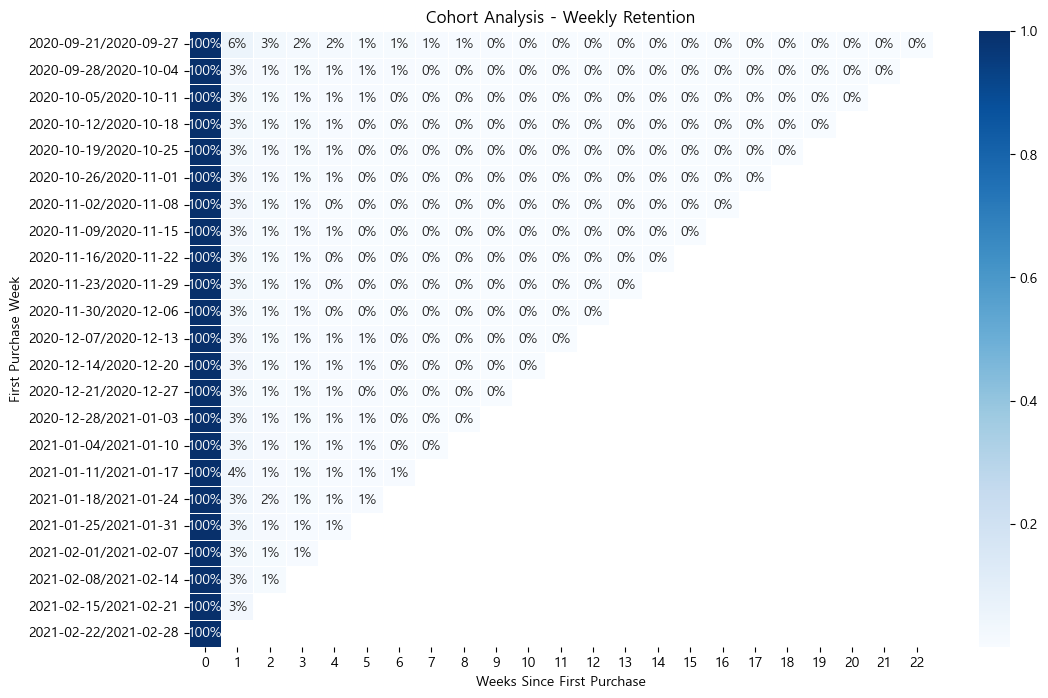

In [20]:
data['cohort_week'] = data.groupby('user_id')['event_time'].transform('min').dt.to_period('W')
data['purchase_week'] = data['event_time'].dt.to_period('W')  # 주 단위

# 코호트 테이블 생성
cohort_data = data.groupby(['cohort_week', 'purchase_week'])['user_id'].nunique().reset_index()

# Cohort Period (최초 구매 후 몇 주 지났는지 계산)
cohort_data['cohort_period'] = (cohort_data['purchase_week'] - cohort_data['cohort_week']).apply(lambda x: x.n)

# 피벗 테이블 생성
cohort_pivot = cohort_data.pivot(index='cohort_week', columns='cohort_period', values='user_id')

# 재구매율 계산 (첫 번째 열 기준)
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

# 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(retention_matrix, annot=True, fmt='.0%', cmap='Blues', linewidths=0.5)
plt.title('Cohort Analysis - Weekly Retention')
plt.ylabel('First Purchase Week')
plt.xlabel('Weeks Since First Purchase')
plt.show()

### 인사이트

첫 주 - 100%  
> 모든 고객 첫 구매  

1 ~ 3주 - 일부 고객이 재구매  
> 특정 코호트 구매 시기별 고객 집단에서 첫 구매 후 1~3주 내에 재구매율이 가장 높은 경향을 보임.  

4주 이후부터는 급격한 감소  
> 대부분의 코호트에서 4주 차 이후에는 재구매율이 1% 이하로 떨어지고, 몇 주 지나면 아예 0%가 됨.  

10주 이후는 거의 재구매 없음  
> 일부 코호트에서 아주 드물게 재구매가 있지만, 거의 없는 수준.  

**비즈니스 인사이트**  

- 첫 3주 내 프로모션, 할인, 쿠폰 제공  
 >이탈하기 전 재구매를 유도하는 전략 필요.
- 4주 이후 고객은 거의 재구매 안 함 -> 재참여 유도 필요  
 >휴면 고객을 위한 리마케팅 시도.  
- 재구매 고객 패턴 분석 필요  
 >왜 3주 내에 재구매하는지, 특정 제품과 연관이 있는지 추가 분석 필요.


5개월 데이터를 사용하다보니 고가의 같은 상품 재구매같은 경우 확인하지 못했다.

___

## 상품 카테고리 기반 분석

전자기기를 구매한 고객들은 단일 제품만 사는 것이 아니라, 연관된 부품이나 보완 제품을 추가로 구매하는 경우가 많다. 예를 들어, 노트북을 산 고객이 이후에 마우스, 키보드, 외장 모니터를 추가 구매하는 경향이 있을 수 있다. 이를 분석하면, 연관 제품 추천 및 번들 마케팅 전략을 세울 수 있다.

In [21]:
# 'purchase' 이벤트만 필터링
purchase_data = data[data['event_type'] == 'purchase']

# category_code에서 마지막 값을 추출 (이름)
purchase_data['category_name'] = purchase_data['category_code'].apply(lambda x: x.split('.')[-1])

# 첫 구매 날짜 추출
purchase_data['event_time'] = pd.to_datetime(purchase_data['event_time'])

# 각 사용자(user_id)의 첫 구매 데이터 추출
first_purchase = purchase_data.groupby('user_id').agg(first_purchase_time=('event_time', 'min'),
                                                      first_purchase_category=('category_name', 'first')).reset_index()

# 첫 구매 후 4주 이내의 추가 구매 추적
purchase_data = purchase_data.merge(first_purchase, on='user_id', how='left')
purchase_data['time_diff'] = (purchase_data['event_time'] - purchase_data['first_purchase_time']).dt.days

# 첫 구매 후 4주 이내 구매만 필터링
purchase_data_within_4w = purchase_data[purchase_data['time_diff'] <= 28]

# 첫 구매 카테고리별로 4주 이내 추가 구매한 카테고리 카운트
purchase_counts = purchase_data_within_4w.groupby(['first_purchase_category', 'category_name']).size().unstack(fill_value=0)

# 'first_purchase_category'별로 각 열(추가 구매 카테고리)을 내림차순으로 정렬
sorted_purchase_counts = purchase_counts.apply(lambda x: x.sort_values(ascending=False), axis=1)

# 첫 구매 카테고리별로 열이 정렬된 테이블을 'first_purchase_category' 기준으로 정렬
sorted_purchase_counts = sorted_purchase_counts.loc[sorted_purchase_counts.sum(axis=1).sort_values(ascending=False).index]

# 첫 구매 카테고리 건수 내림차순으로 상위 20개만 선택
top_20_first_purchase_categories = sorted_purchase_counts.sum(axis=1).head(20)

# 출력 데이터 준비
output_data = []

for first_category in top_20_first_purchase_categories.index:
    # 첫 구매 카테고리
    first_purchase_category = first_category
    
    # 상위 3개의 추가 구매 카테고리 (자기 자신과 etc 제외)
    top_categories = sorted_purchase_counts.loc[first_category].sort_values(ascending=False)
    top_categories = top_categories[top_categories.index != first_purchase_category]
    top_categories = top_categories[top_categories.index != 'etc']  # etc 제외
    
    # 상위 3개 카테고리
    top_1 = top_categories.index[0] if len(top_categories) > 0 else None
    top_2 = top_categories.index[1] if len(top_categories) > 1 else None
    top_3 = top_categories.index[2] if len(top_categories) > 2 else None
    
    # 결과 추가
    output_data.append([first_purchase_category, top_1, top_2, top_3])

# 결과를 DataFrame으로 변환
output_df = pd.DataFrame(output_data, columns=['First Purchase Category', 'Top 1', 'Top 2', 'Top 3'])

# 출력
print(output_df.to_string(index=False))

First Purchase Category      Top 1         Top 2          Top 3
                    etc videocards           cpu    motherboard
             videocards        cpu   motherboard   power_supply
              telephone  headphone       printer        desktop
               cartrige    printer         paper           wifi
                printer   cartrige           hdd         tablet
            motherboard        cpu    videocards   power_supply
               notebook     cooler     telephone            hdd
                    cpu videocards   motherboard   power_supply
               acoustic     player        camera       shelving
                 tablet  telephone      joystick      headphone
                 player   acoustic      notebook       painting
                 camera   acoustic videoregister        printer
                    hdd        cpu    videocards   power_supply
           power_supply videocards           cpu    motherboard
                   wifi     camera      

C:\Users\whgus\AppData\Local\Temp\ipykernel_8768\2543451512.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_data['category_name'] = purchase_data['category_code'].apply(lambda x: x.split('.')[-1])
C:\Users\whgus\AppData\Local\Temp\ipykernel_8768\2543451512.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_data['event_time'] = pd.to_datetime(purchase_data['event_time'])


### 인사이트

한 부품을 사고 부속 부품을 사는 경향이 많다면 묶음 판매나 쿠폰을 제공해 구매 유도한다.

구매율 1위 비디오카드 구매 후 가장 많이 구매한 제품은 
> **cpu** , **motherboard** , **power_supply**

프린터같은 경우 
> **cartrige** , hdd , tablet

노트북은 
> **cooler**, telephone, hdd

**비즈니스 인사이트**  - 연관 제품 세트 판매 및 프로모션 진행
  > 세트 상품 및 쿠폰으로 부속 제품 구매 유도

- 연관 제품 맞춤 광고 마케팅
  > 개인화된 추천 시스템 알림 제공분석 필요.

※ etc의 경우 데이터에서 상당한 양을 차지하고 어떠한 제품인지 알 수 없어 제외함



---

## 추가 분석

### 세션 기반 분석

전자기기를 구매하는 고객들은 일반적으로 제품을 비교하고 검토하면서 긴 시간 고민한 후 구매하거나 사전에 정보를 조사해 바로 구매를 결정한다. 세션 분석을 통해, 세션 별 머무른 시간 대비 정보들을 파악해보자.

In [22]:
# 기본 정보 파악
data_for_session.info()

<class 'pandas.core.frame.DataFrame'>
Index: 648311 entries, 0 to 885128
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   event_time       648311 non-null  object 
 1   event_type       648311 non-null  object 
 2   product_id       648311 non-null  int64  
 3   category_id      648311 non-null  int64  
 4   category_code    648311 non-null  object 
 5   brand            648311 non-null  object 
 6   price            648311 non-null  float64
 7   user_id          648311 non-null  int64  
 8   user_session     648311 non-null  object 
 9   category_code_1  648311 non-null  object 
 10  category_code_2  648311 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 59.4+ MB


In [23]:
data_for_session.head(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category_code_1,category_code_2
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,etc,31.90,1515915625519388267,LJuJVLEjPT,electronics,telephone
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY,computers,cooler
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08,computers,printer
5,2020-09-24 11:57:59 UTC,view,664325,2144415951611757447,construction.tools.saw,carver,52.33,1515915625519388062,vnkdP81DDW,construction,saw
6,2020-09-24 11:58:23 UTC,view,3791349,2144415935086199225,computers.desktop,etc,215.41,1515915625519388877,J1t6sIYXiV,computers,desktop


In [24]:
# 한 유저가 몇개의 로그를 가지고 있는지 파악하기
user_counts = data_for_session['user_id'].value_counts().reset_index()
user_counts.columns = ['user_id', 'count']
user_counts = user_counts.sort_values(by='count', ascending=False)

print(user_counts.head(10))  # 상위 10개 출력

               user_id  count
0  1515915625554995474    572
1  1515915625527763086    424
2  1515915625591251010    361
3  1515915625591659523    319
4  1515915625568273951    312
5  1515915625599852988    267
6  1515915625596734979    238
7  1515915625593056776    231
8  1515915625556087775    224
9  1515915625593948004    219


In [25]:
# 데이터 확인
data_for_session[data_for_session['user_id']==1515915625554995474]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category_code_1,category_code_2
410322,2020-12-08 06:13:31 UTC,view,3979136,2144415923744800906,appliances.environment.vacuum,bosch,297.19,1515915625554995474,nFlhu5QzOd,appliances,vacuum
410323,2020-12-08 06:13:38 UTC,view,3979025,2144415923744800906,appliances.environment.vacuum,bosch,350.60,1515915625554995474,nFlhu5QzOd,appliances,vacuum
410324,2020-12-08 06:13:45 UTC,view,3978887,2144415923744800906,appliances.environment.vacuum,bosch,369.17,1515915625554995474,nFlhu5QzOd,appliances,vacuum
410394,2020-12-08 06:36:13 UTC,view,483337,2144415923744800906,appliances.environment.vacuum,thomas,365.25,1515915625554995474,nFlhu5QzOd,appliances,vacuum
410395,2020-12-08 06:36:27 UTC,view,669304,2144415923744800906,appliances.environment.vacuum,thomas,478.59,1515915625554995474,nFlhu5QzOd,appliances,vacuum
...,...,...,...,...,...,...,...,...,...,...,...
825626,2021-02-18 07:48:51 UTC,view,247085,2144415923744800906,appliances.environment.vacuum,thomas,262.48,1515915625554995474,nFlhu5QzOd,appliances,vacuum
825699,2021-02-18 07:59:38 UTC,view,483337,2144415923744800906,appliances.environment.vacuum,thomas,365.25,1515915625554995474,nFlhu5QzOd,appliances,vacuum
825700,2021-02-18 07:59:43 UTC,view,847412,2144415923744800906,appliances.environment.vacuum,thomas,120.00,1515915625554995474,nFlhu5QzOd,appliances,vacuum
825701,2021-02-18 07:59:47 UTC,view,37774,2144415923744800906,appliances.environment.vacuum,thomas,167.62,1515915625554995474,nFlhu5QzOd,appliances,vacuum


- 데이터를 확인하며 위처럼 모든 기간 같은 세션인 오류를 찾았다. 위 같은 경우를 제거하자.

In [26]:
# 날짜 변환
data_for_session['event_time'] = pd.to_datetime(data_for_session['event_time'])

# user_id, user_session 기준으로 세션 지속 시간 계산
session_check = data_for_session.groupby(['user_id', 'user_session']).agg(
    session_start=('event_time', 'min'),
    session_end=('event_time', 'max')
).reset_index()

# 세션 지속 시간 계산 (단위: 시간)
session_check['session_length_hours'] = (session_check['session_end'] - session_check['session_start']).dt.total_seconds() / 3600

# 7일(168시간) 이상 지속된 세션 찾기
invalid_sessions = session_check[session_check['session_length_hours'] >= 168][['user_id', 'user_session']]

# 원본 데이터에서 제거
cleaned_data = data_for_session.merge(invalid_sessions, on=['user_id', 'user_session'], how='left', indicator=True)
cleaned_data = cleaned_data[cleaned_data['_merge'] == 'left_only'].drop(columns=['_merge'])

# 세션 데이터 정리 완료
print(f"제거된 비정상 세션 개수: {len(invalid_sessions)}")
print(f"정상 데이터 개수: {len(cleaned_data)}")

C:\Users\whgus\AppData\Local\Temp\ipykernel_8768\1660455650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_session['event_time'] = pd.to_datetime(data_for_session['event_time'])


제거된 비정상 세션 개수: 3106
정상 데이터 개수: 617615


### 세션 별 지속시간과 구매 횟수

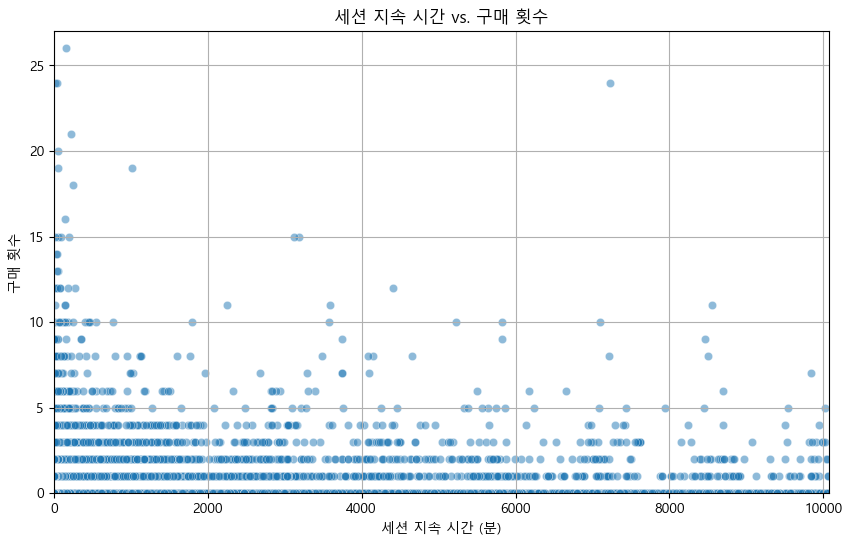

In [27]:
session_stats = cleaned_data.groupby(['user_id', 'user_session']).agg(
    session_length=('event_time', lambda x: (x.max() - x.min()).total_seconds() / 60),  # 단위: 분
    purchase_count=('event_type', lambda x: (x == 'purchase').sum())  # 'purchase' 이벤트 수
).reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(data=session_stats, x='session_length', y='purchase_count', alpha=0.5)
plt.xlabel('세션 지속 시간 (분)')
plt.ylabel('구매 횟수')
plt.title('세션 지속 시간 vs. 구매 횟수')
plt.xlim(0, session_stats['session_length'].max())  # 0부터 최대 값까지 표시
plt.ylim(0, session_stats['purchase_count'].max() + 1)
plt.grid(True)
plt.show()

- 세션 지속 시간이 너무 길어 자세한 파악이 어렵다. 
- 위 그래프의 경우 한 눈에 파악하기 쉽지 않으므로 세션 구간을 나누어 구매횟수를 표현한 막대 그래프로 나타냈다.

In [32]:
# 구매 이벤트만 따로 필터링
purchases = cleaned_data[cleaned_data['event_type'] == 'purchase']

# 세션별 시작 시간과 구매 시간 계산
session_start = cleaned_data.groupby(['user_id', 'user_session'])['event_time'].min()
purchase_time = purchases.groupby(['user_id', 'user_session'])['event_time'].min()

# 구매까지 걸린 시간 계산 (분 단위)
time_to_purchase = (purchase_time - session_start).dt.total_seconds() / 60
time_to_purchase = time_to_purchase.dropna().rename('time_to_purchase')


In [35]:
# 구간 정의
bins = [0, 5, 10, 30, 60, float('inf')]
labels = ['0-5분', '5-10분', '10-30분', '30-60분', '60분 이상']
time_to_purchase_group = pd.cut(time_to_purchase, bins=bins, labels=labels, include_lowest=True)

# 데이터프레임으로 정리
purchase_time_df = time_to_purchase_group.reset_index().rename(columns={'time_to_purchase': 'purchase_time_group'})


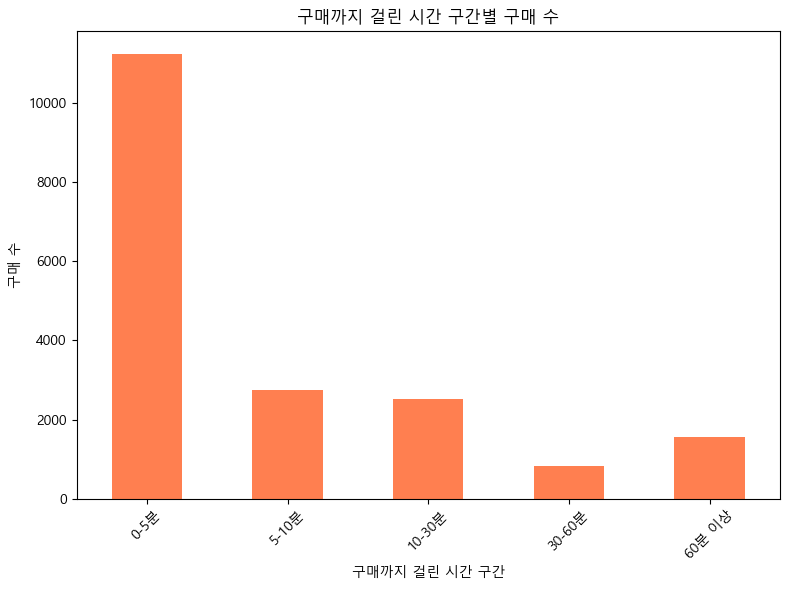

In [37]:
# 각 구간별 구매 수 (time_to_purchase가 있는 경우만 해당되므로 이미 구매 발생한 세션들임)
purchase_counts_by_group = purchase_time_df['purchase_time_group'].value_counts().sort_index()

# 시각화
plt.figure(figsize=(8, 6))
purchase_counts_by_group.plot(kind='bar', color='coral')
plt.title('구매까지 걸린 시간 구간별 구매 수')
plt.xlabel('구매까지 걸린 시간 구간')
plt.ylabel('구매 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- 깔끔하게 정리된 모습
- 예상과 달리 짧은 시간에 구매가 대부분이다(사전에 미리 제품 파악 후 구매 패턴)
- 시간이 길어질수록 구매 횟수가 줄어드는 추세이다.
- 60분 이상에서 소폭 증가한다.

## 추가 궁금증
- 구매까지 걸린 시간인 위 그래프에서 가격에 따른 인사이트가 있을까?

In [78]:
# 구매 이벤트만 필터링
purchases = cleaned_data[cleaned_data['event_type'] == 'purchase'].copy()

# 세션 시작 시간과 구매 시간 계산
session_start = cleaned_data.groupby(['user_id', 'user_session'])['event_time'].min()
purchase_time = purchases.groupby(['user_id', 'user_session'])['event_time'].min()

# 구매까지 걸린 시간 계산
purchases['session_start'] = purchases.set_index(['user_id', 'user_session']).index.map(session_start)
purchases['purchase_time'] = purchases.set_index(['user_id', 'user_session']).index.map(purchase_time)
purchases['time_to_purchase'] = (purchases['purchase_time'] - purchases['session_start']).dt.total_seconds() / 60

# 시간 구간 지정
bins = [0, 5, 10, 30, 60, float('inf')]
labels = ['0-5분', '5-10분', '10-30분', '30-60분', '60분 이상']
purchases['purchase_time_group'] = pd.cut(purchases['time_to_purchase'], bins=bins, labels=labels, include_lowest=True)

# 가격대 구분 함수 적용
def categorize_price(price):
    if price <= 50:
        return '0-50 달러'
    elif price <= 200:
        return '50-200 달러'
    else:
        return '200+ 달러'

purchases['price_category'] = purchases['price'].apply(categorize_price)


C:\Users\whgus\AppData\Local\Temp\ipykernel_8768\4158023472.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  purchase_counts = purchases.groupby(['purchase_time_group', 'price_category'])['user_id'].count().unstack(fill_value=0)


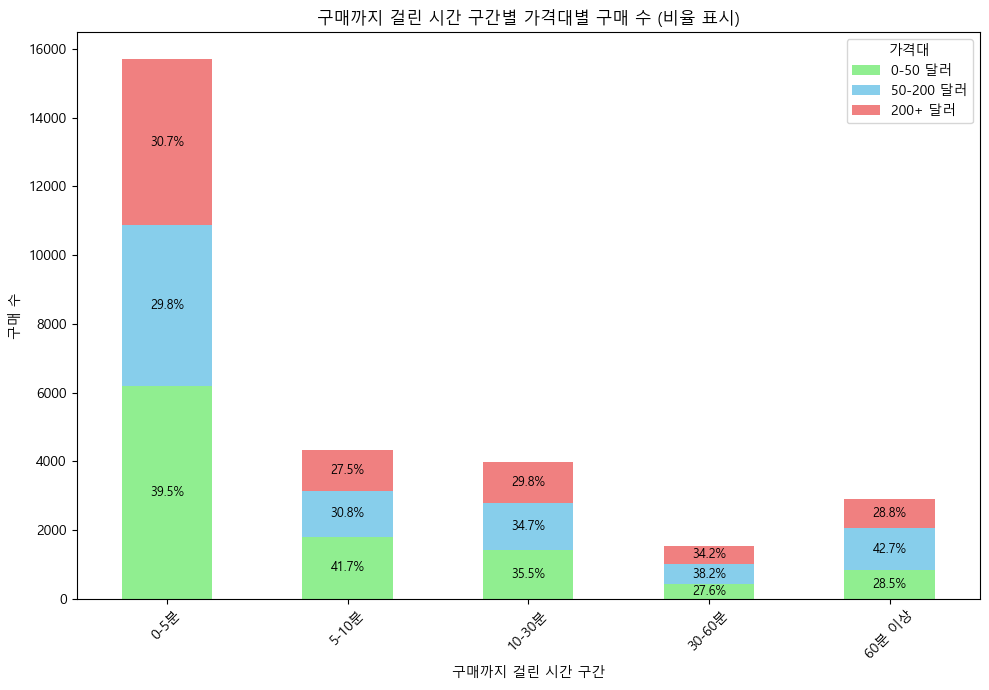

In [79]:
# 1. 절대 구매 수 테이블
purchase_counts = purchases.groupby(['purchase_time_group', 'price_category'])['user_id'].count().unstack(fill_value=0)

# 2. 전체 비율 계산 (가격대 기준)
total_counts = purchase_counts.sum()
total_ratios = total_counts / total_counts.sum()

# 3. 비율 높은 순서로 컬럼 정렬
sorted_categories = total_ratios.sort_values(ascending=False).index.tolist()
purchase_counts = purchase_counts[sorted_categories]

# 4. 다시 비율 (%) 계산
purchase_ratio = purchase_counts.div(purchase_counts.sum(axis=1), axis=0) * 100

# 5. 색상도 정렬된 순서로 매칭
color_map = {
    '0-50 달러': 'lightgreen',
    '50-200 달러': 'skyblue',
    '200+ 달러': 'lightcoral'
}
colors_sorted = [color_map[cat] for cat in sorted_categories]

# 6. 시각화
fig, ax = plt.subplots(figsize=(10, 7))
bars = purchase_counts.plot(kind='bar', stacked=True, ax=ax, color=colors_sorted)

plt.title('구매까지 걸린 시간 구간별 가격대별 구매 수 (비율 표시)')
plt.xlabel('구매까지 걸린 시간 구간')
plt.ylabel('구매 수')
plt.xticks(rotation=45)

# 7. 바 내부에 비율 (%) 표시
for i, container in enumerate(ax.containers):
    for j, bar in enumerate(container):
        height = bar.get_height()
        if height > 0:
            total = purchase_counts.iloc[j].sum()
            ratio = (height / total) * 100
            ax.annotate(f'{ratio:.1f}%', 
                        (bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                        ha='center', va='center', fontsize=9)

# 8. 범례도 정렬된 순서로 표시
handles, labels = ax.get_legend_handles_labels()
legend_sorted = [(label, handle) for label, handle in zip(labels, handles)]
legend_sorted = sorted(legend_sorted, key=lambda x: total_ratios[x[0]], reverse=True)
sorted_labels, sorted_handles = zip(*legend_sorted)
ax.legend(sorted_handles, sorted_labels, title='가격대')

plt.tight_layout()
plt.show()


- 0~50달러의 경우 구매까지 걸린 시간 비율이 낮아지는 경향
- 50~200달러의 경우 시간이 지날수록 그 비율이 증가하는 추세
- 200+ 달러의 경우 비교적 균등한 분포

**구매를 결정한 제품의 가격이 200+ 이상인 경우 이전 VIEW나 CART 내력이 있는지 확인할 필요가 있다.**

In [82]:
# 세션 시간 구간 리스트
time_bins = ['0-5분', '5-10분', '10-30분', '30-60분', '60분 이상']

# 결과 저장할 리스트
results = []

for time_bin in time_bins:
    # 1. 해당 시간 구간 + 200+ 달러 제품 구매 대상 필터링
    target_purchases = purchases[
        (purchases['purchase_time_group'] == time_bin) &
        (purchases['price_category'] == '200+ 달러')
    ].copy()

    # 필요한 정보만 추출
    target_keys = target_purchases[['user_id', 'user_session', 'product_id', 'purchase_time']]

    # 2. view/cart 이벤트만 따로 추출
    prior_events = cleaned_data[cleaned_data['event_type'].isin(['view', 'cart'])].copy()

    # 같은 user + product에 대해, 구매보다 과거에 view/cart 한 경우 필터 (단, session은 달라야 함)
    merged = pd.merge(
        target_keys,
        prior_events,
        on=['user_id', 'product_id'],
        suffixes=('_purchase', '_event')
    )

    # 구매보다 과거 이벤트 + 세션이 다름
    merged['event_before_purchase'] = (
        (merged['event_time'] < merged['purchase_time']) &
        (merged['user_session_purchase'] != merged['user_session_event'])
    )

    # 과거 다른 세션에서 본 적 있는 경우만 추출
    prior_engagement = merged[merged['event_before_purchase']]

    # 사용자 수 & 비율 계산
    users_with_prior_view_cart = prior_engagement[['user_id', 'user_session_purchase', 'product_id']].drop_duplicates().shape[0]
    total_target_users = target_keys.shape[0]
    prior_view_cart_ratio = users_with_prior_view_cart / total_target_users if total_target_users > 0 else 0

    # 결과 저장
    results.append({
        '구매까지 걸린 시간': time_bin,
        '200+ 달러 제품 구매자 수': total_target_users,
        '과거 다른 세션에서 view/cart 한 사용자 수': users_with_prior_view_cart,
        '비율 (%)': f"{prior_view_cart_ratio:.2%}"
    })

# 데이터프레임 변환 후 출력
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


  구매까지 걸린 시간  200+ 달러 제품 구매자 수  과거 다른 세션에서 view/cart 한 사용자 수  비율 (%)
0       0-5분              4825                          1499  31.07%
1      5-10분              1193                           200  16.76%
2     10-30분              1183                           208  17.58%
3     30-60분               526                            74  14.07%
4     60분 이상               834                           181  21.70%


### 인사이트

- 예상과 달리 짧은 시간에 구매를 결정하는 경우가 많다 - 즉흥적 구매가 강력함
  > 0~5분, 200+달러 이상 제품 구매의 경우 사전에 확인한 비율은 31.07%  
  > 고가 제품에도 불구하고 빠른 구매 결정  
  > 60분 이상 신중히 고민하는 고객도 존재 
- 시간이 길어질수록 구매 횟수가 줄어드는 추세이다.
- 가격대가 중고가인 제품의 경우 시간이 지날수록 비율이 증가한다.

**비즈니스 인사이트**  

세션 시간이 짧은 구매 고객
> 즉흥 구매 강력 - 구매 과정 간소화 (원클릭 결제, 간편 결제)

세션 시간이 긴 구매 고객
> 제품 비교 기능 추가 및 관련된 제품을 추천하여 고객의 제품 결정 및 구매에 도움을 줄 수 있게한다

---

## 정리 및 제안

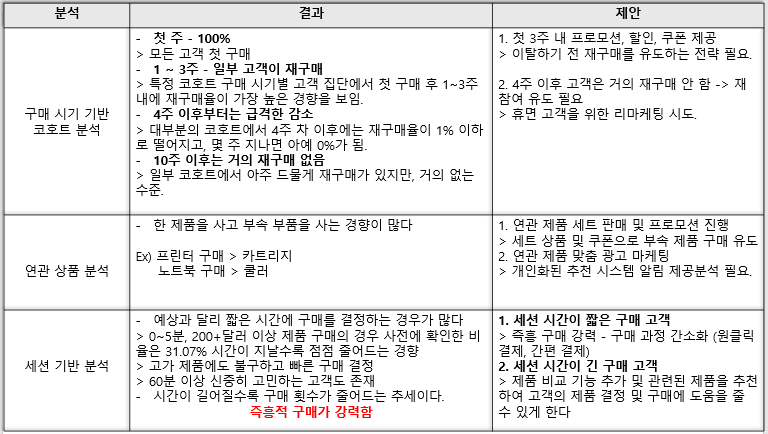